In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, recall_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.optimizers import SGD
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD

In [178]:
#import data
df = pd.read_csv('./bank-additional/bank-additional-full.csv', sep=';')
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

## Data cleaning

In [179]:
#rename some of the columns
df.columns = df.columns.str.replace('.','_')
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [180]:
# change admin. in job
df['job']=df.job.apply(lambda x: x.strip('. '))

In [181]:
# drop duration, there is no duration 
#df.drop(columns=['duration'], inplace=True)

In [182]:
df["education"] = df["education"].replace({"basic.4y":"basic", "basic.6y":"basic", "basic.9y":"basic"})

In [183]:
# select the subscribers to analyze their behaviors
df= df[(df.y == "yes")]

In [184]:
# missing data

df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

no missing value

In [185]:
numerical_df = df.select_dtypes(include=np.number)
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4640 entries, 75 to 41186
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4640 non-null   int64  
 1   duration        4640 non-null   int64  
 2   campaign        4640 non-null   int64  
 3   pdays           4640 non-null   int64  
 4   previous        4640 non-null   int64  
 5   emp_var_rate    4640 non-null   float64
 6   cons_price_idx  4640 non-null   float64
 7   cons_conf_idx   4640 non-null   float64
 8   euribor3m       4640 non-null   float64
 9   nr_employed     4640 non-null   float64
dtypes: float64(5), int64(5)
memory usage: 398.8 KB


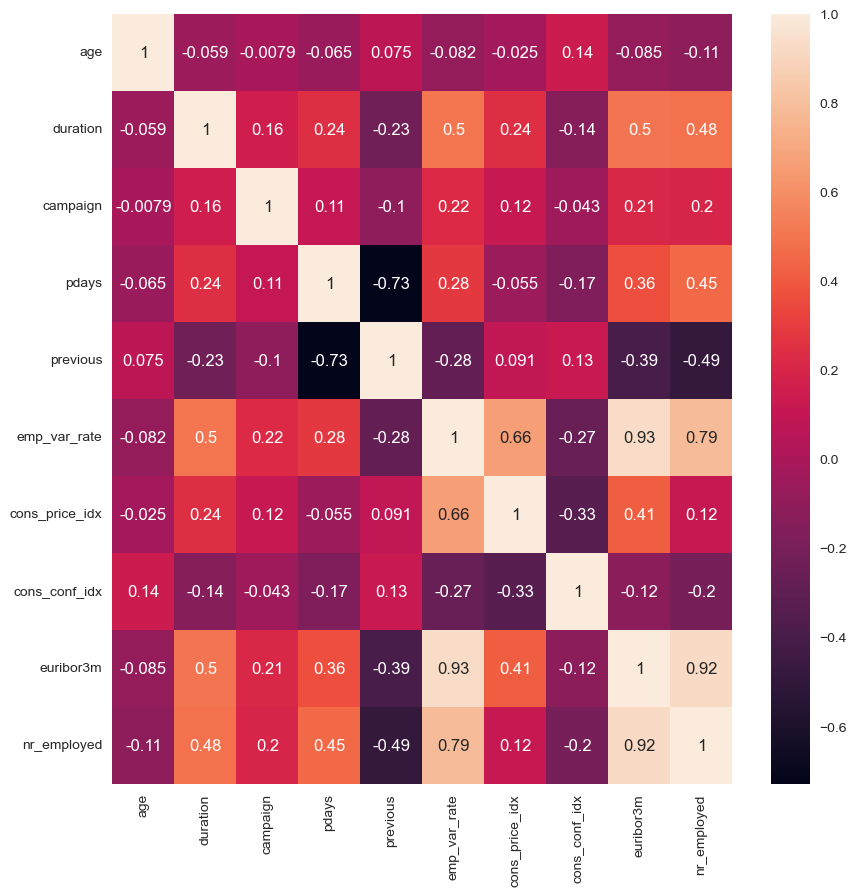

In [186]:
correlations = numerical_df.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(correlations, annot = True)
plt.show();

Strong Positive Correlation between 'pdays' and 'previous'

### FIND THE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

In [187]:
scaler = StandardScaler()
scaler.fit(numerical_df)
ds_scaled = scaler.transform(numerical_df)
scaled_df = pd.DataFrame(ds_scaled,columns= numerical_df.columns)

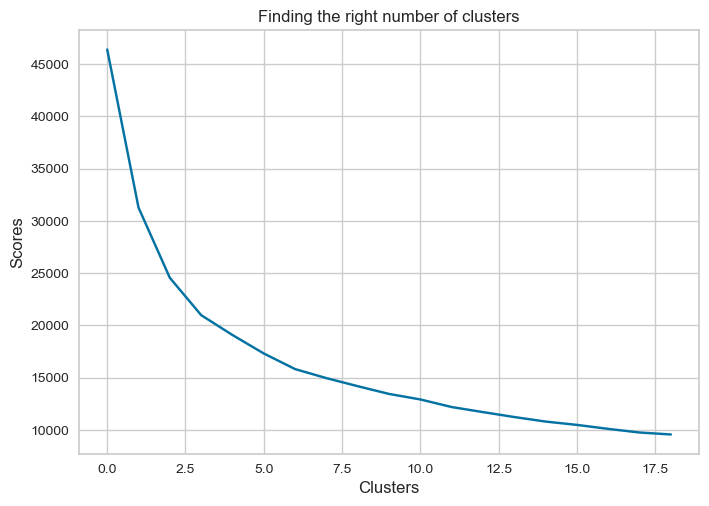

In [188]:
scores_1 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters = i)
  kmeans.fit(scaled_df)
  scores_1.append(kmeans.inertia_) 

plt.plot(scores_1, 'bx-')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores') 
plt.show()

#### Let's choose the number of clusters to be 4.

In [189]:
kmeans = KMeans(4, random_state=5)
kmeans.fit(scaled_df)
labels = kmeans.labels_

In [190]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [numerical_df.columns])
cluster_centers 

age  duration  campaign     pdays  previous emp_var_rate  \
0  0.301304 -0.525505 -0.196001 -0.206625  0.119931    -1.166032   
1 -0.102000  0.766471  0.311486  0.509412 -0.550102     1.429322   
2  0.088700 -0.410601 -0.185274 -1.808178  1.630560    -0.305821   
3 -0.113866 -0.154388 -0.063519  0.513096 -0.356389    -0.398529   

  cons_price_idx cons_conf_idx euribor3m nr_employed  
0      -1.330337      1.521403 -0.762633   -0.632210  
1       0.669300     -0.023424  1.548640    1.378932  
2       0.663080     -0.105549 -0.697282   -0.984383  
3      -0.144713     -0.717317 -0.525352   -0.328733

In [191]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [numerical_df.columns])
cluster_centers

age    duration  campaign       pdays  previous emp_var_rate  \
0  45.081986  342.396074  1.725173  708.690531  0.595843    -3.126443   
1  39.501870  860.644727  2.570681  997.513837  0.019447     1.086986   
2  42.140397  388.487417  1.743046   62.682119  1.895364    -1.729934   
3  39.337693  491.261593  1.945898  999.000000  0.186088    -1.880440   

  cons_price_idx cons_conf_idx euribor3m  nr_employed  
0      92.454319    -30.449885  0.794315  5039.757621  
1      93.807215    -39.933583  4.821500  5215.859686  
2      93.803007    -40.437748  0.908184  5008.920265  
3      93.256477    -44.193401  1.207756  5066.331094

In [192]:
# concatenate the clusters labels to our original dataframe
numerical_df_cluster = pd.concat([numerical_df, pd.DataFrame({'cluster':labels})], axis = 1)
numerical_df_cluster.head()

age  duration  campaign  pdays  previous  emp_var_rate  cons_price_idx  \
75   41.0    1575.0       1.0  999.0       0.0           1.1          93.994   
83   49.0    1042.0       1.0  999.0       0.0           1.1          93.994   
88   49.0    1467.0       1.0  999.0       0.0           1.1          93.994   
129  41.0     579.0       1.0  999.0       0.0           1.1          93.994   
139  45.0     461.0       1.0  999.0       0.0           1.1          93.994   

     cons_conf_idx  euribor3m  nr_employed  cluster  
75           -36.4      4.857       5191.0      1.0  
83           -36.4      4.857       5191.0      1.0  
88           -36.4      4.857       5191.0      1.0  
129          -36.4      4.857       5191.0      1.0  
139          -36.4      4.857       5191.0      1.0

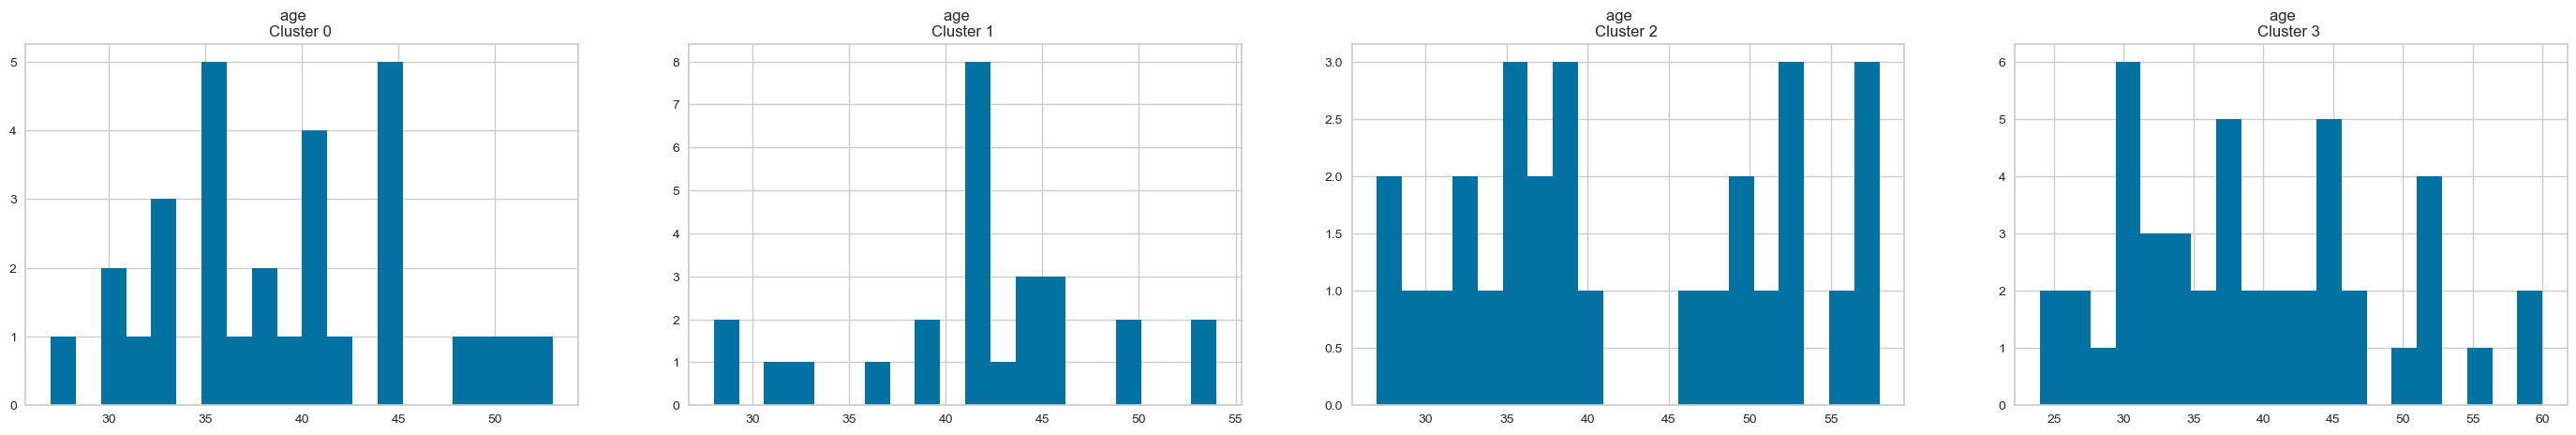

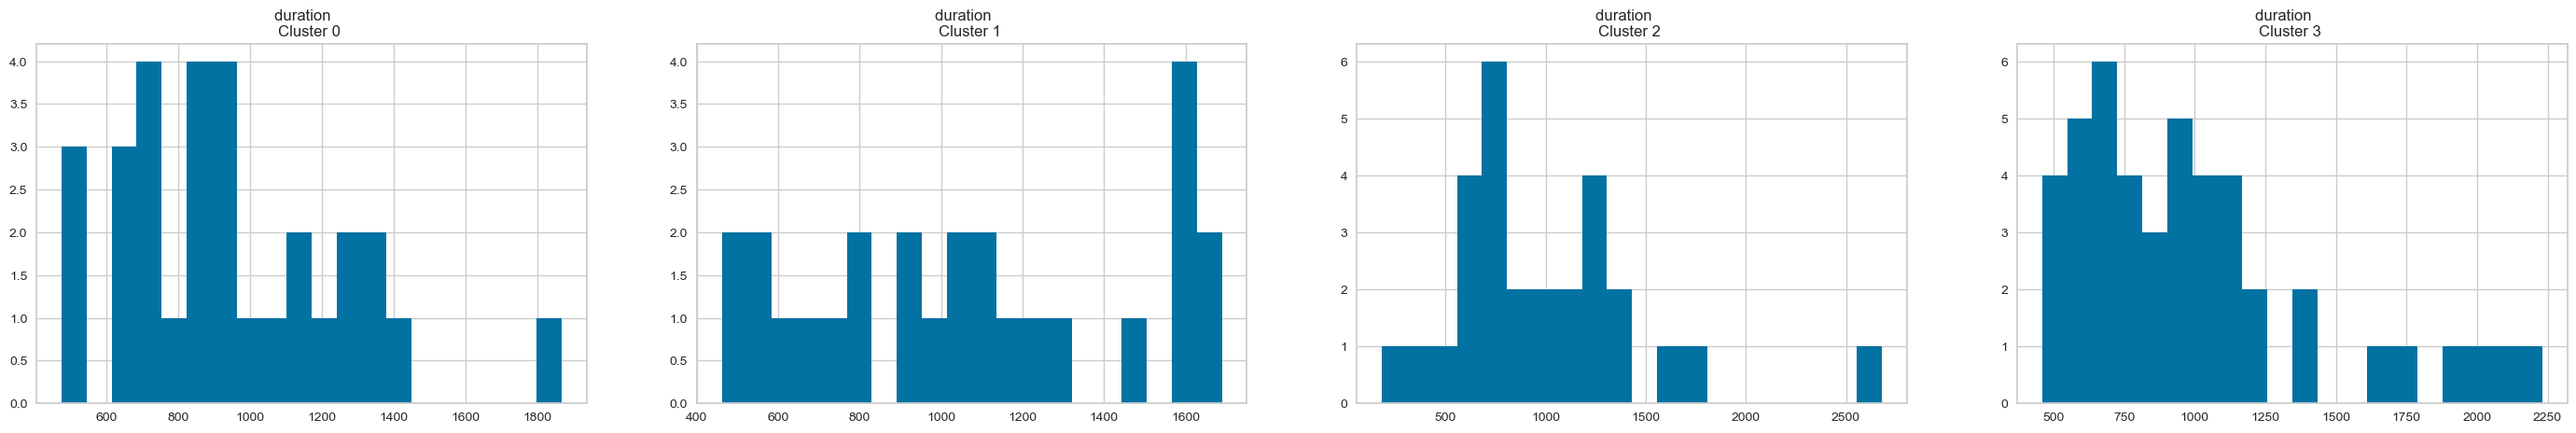

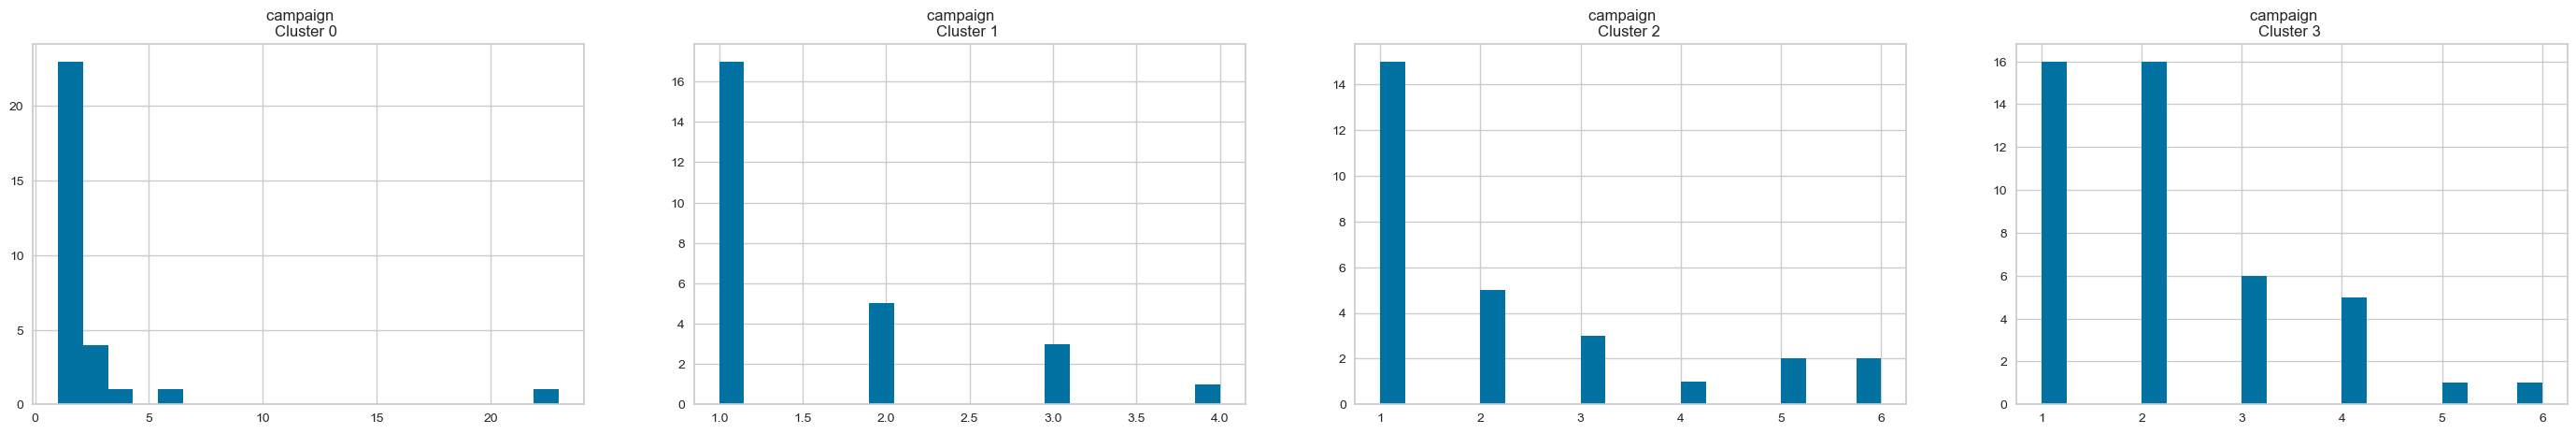

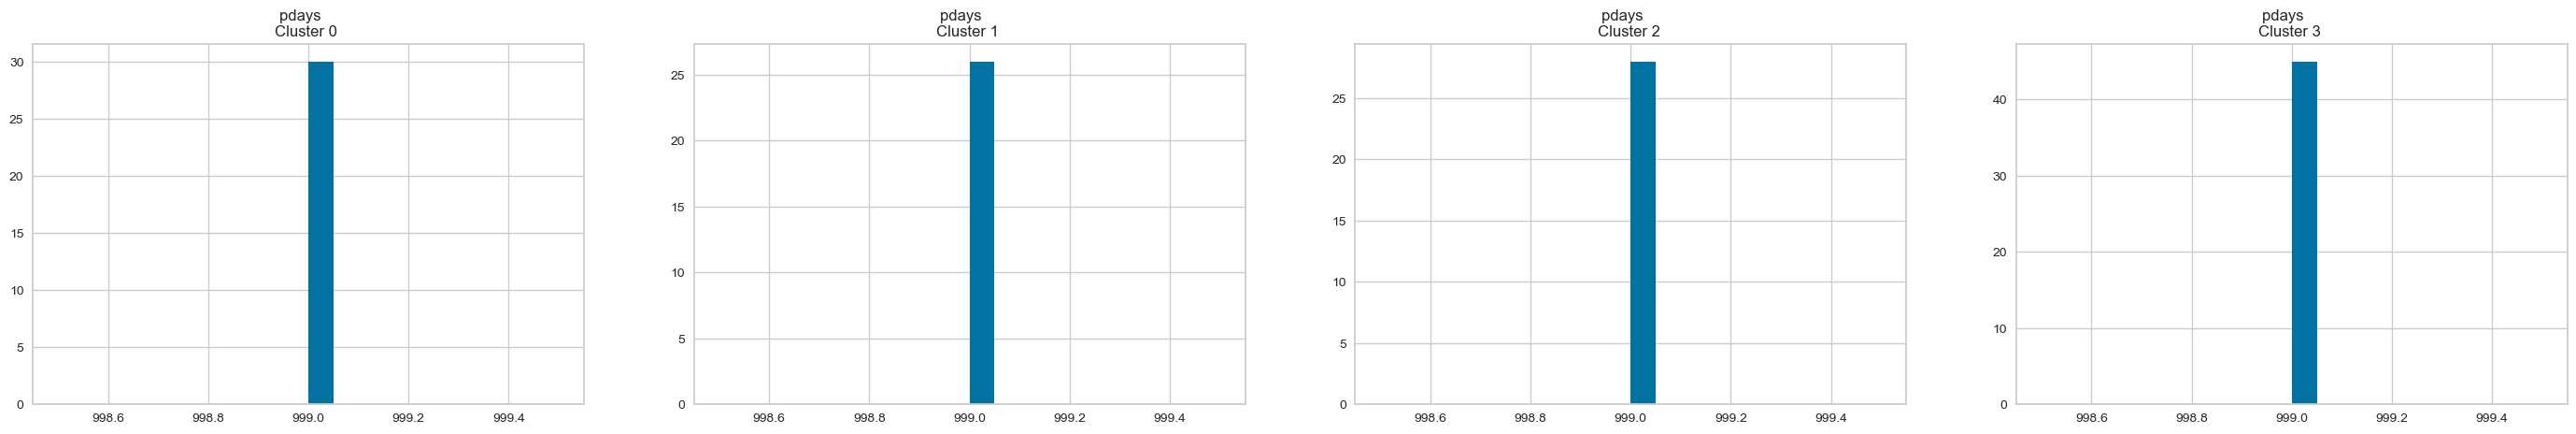

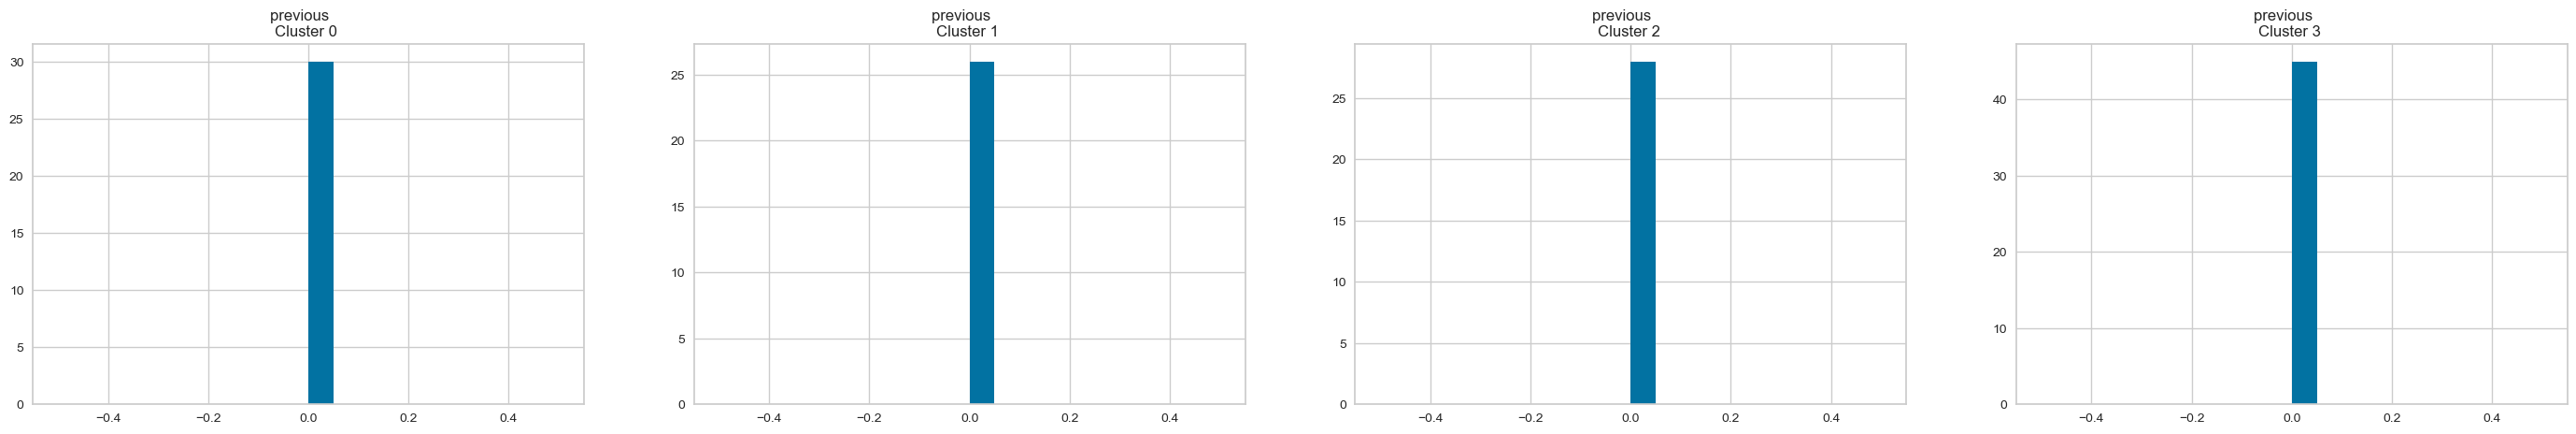

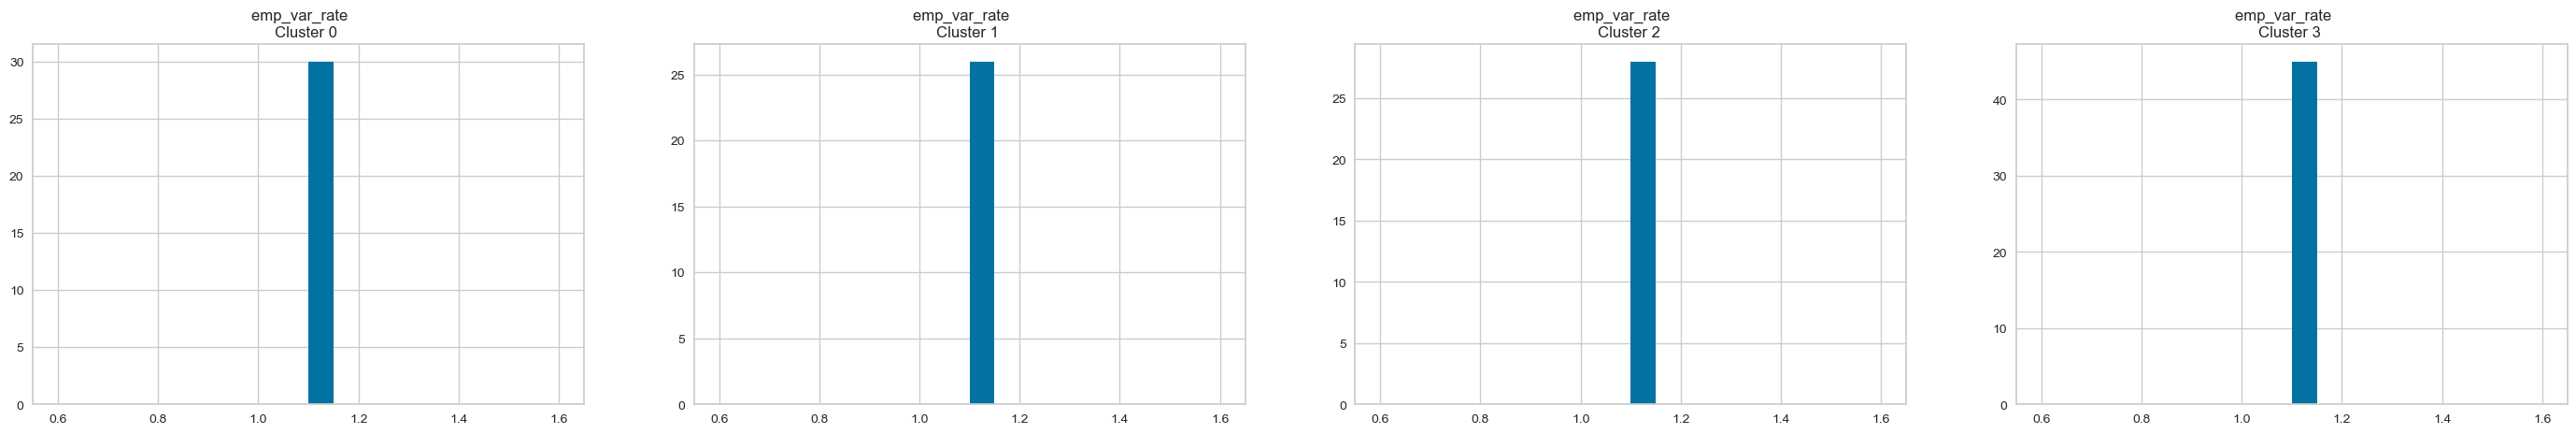

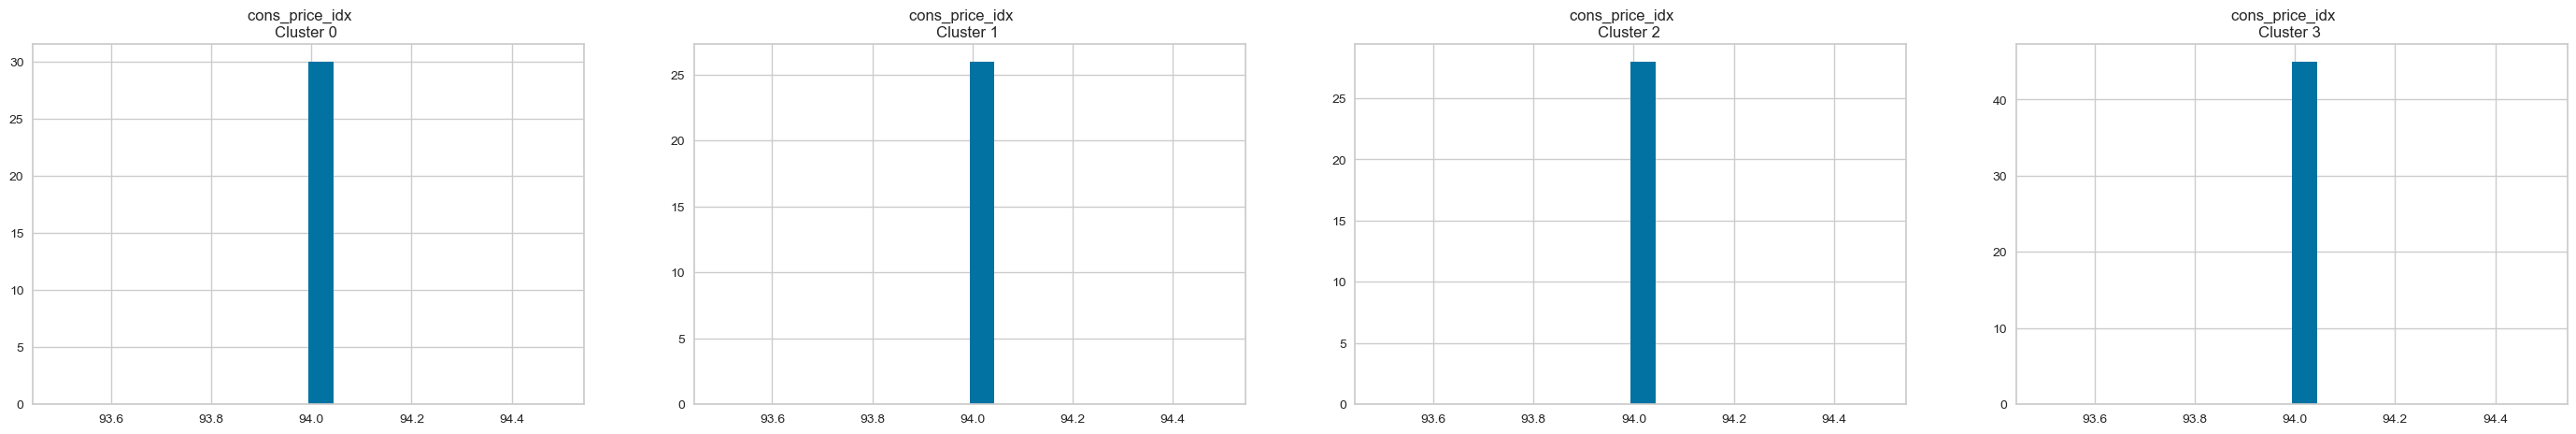

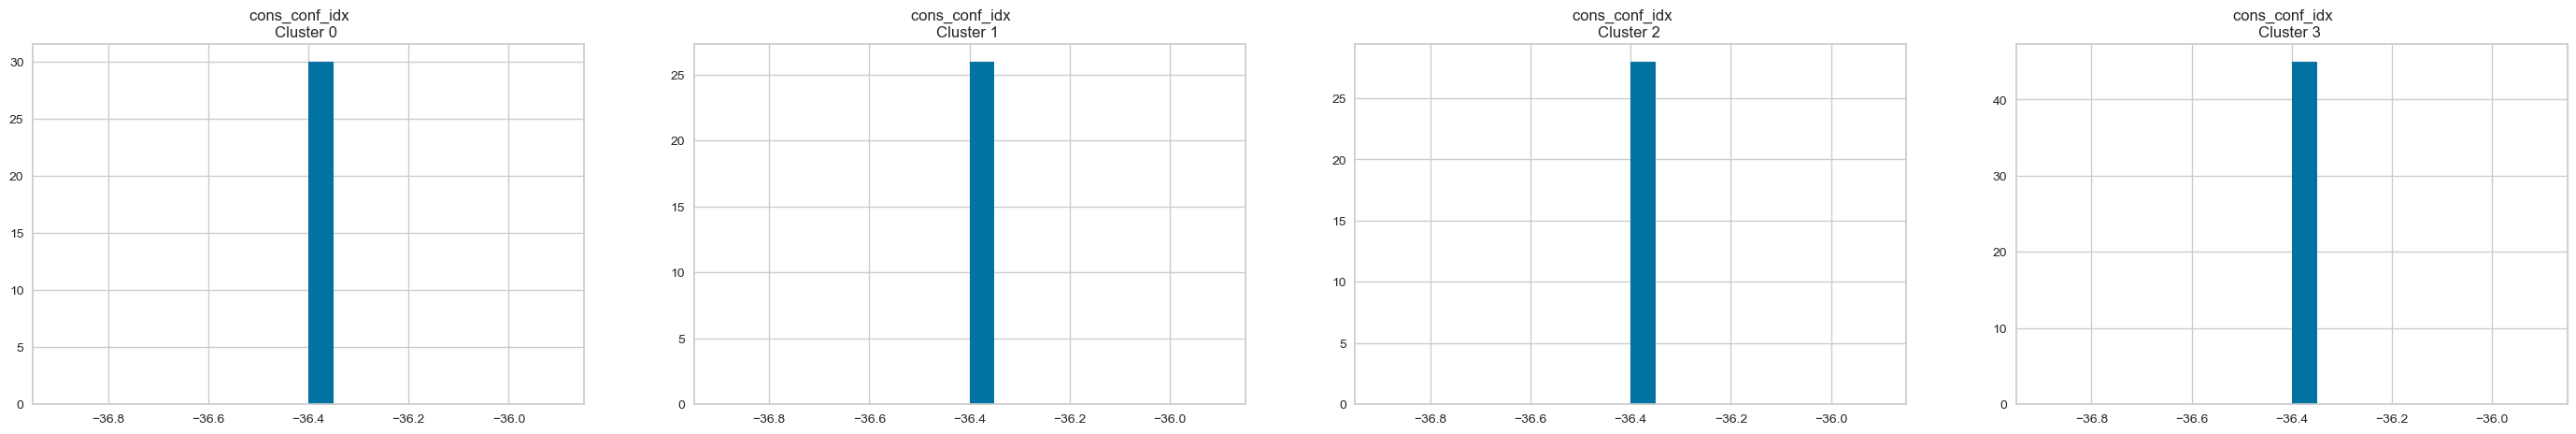

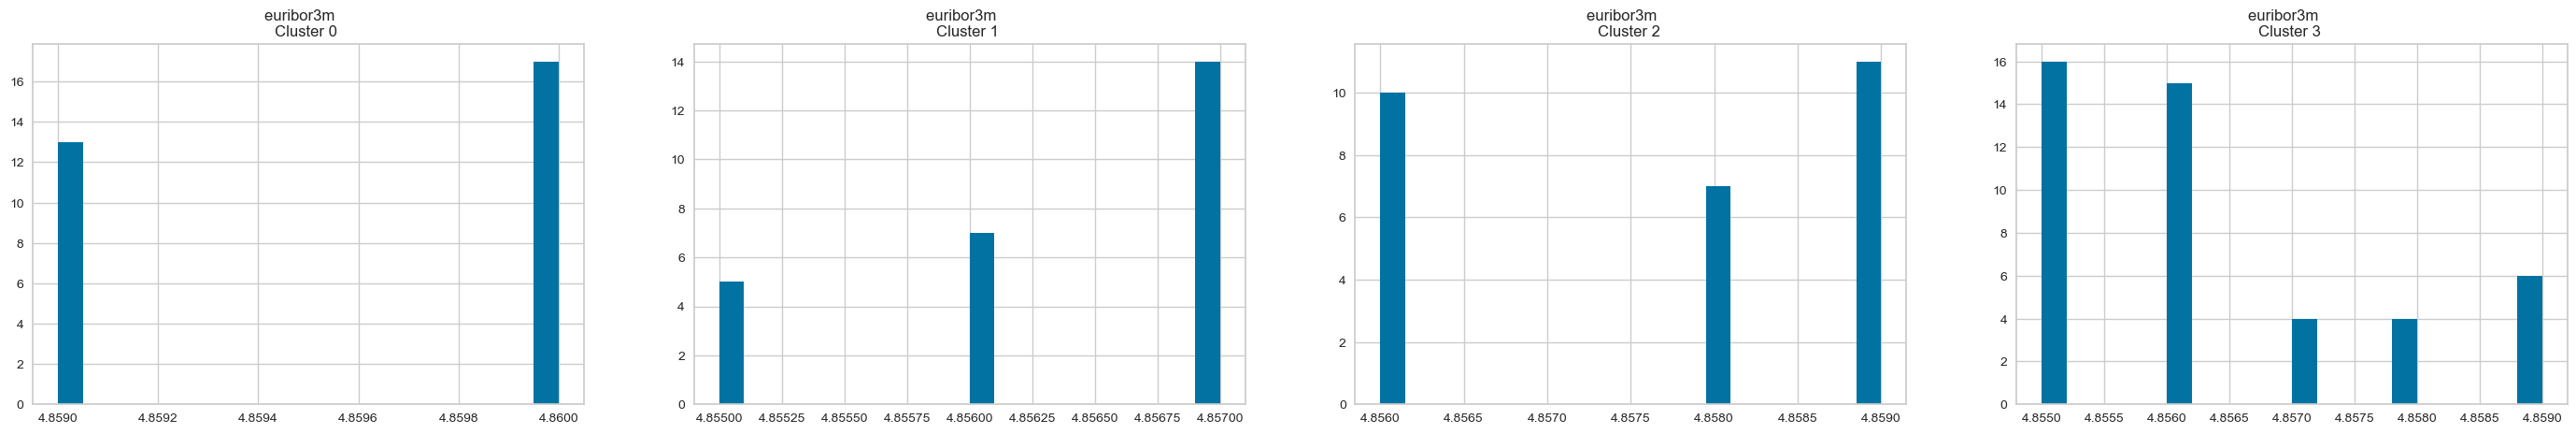

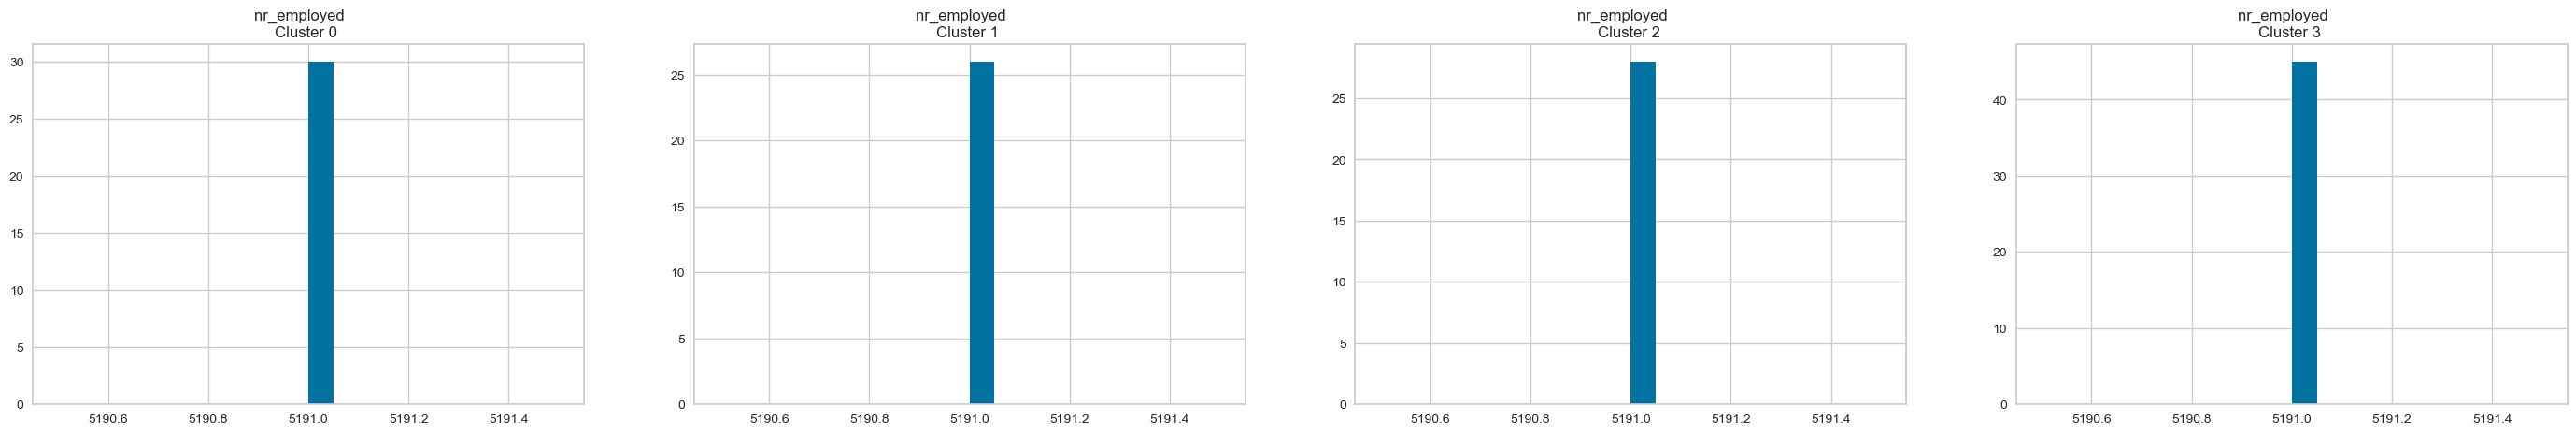

In [193]:
# Plot the histogram of various clusters
for i in numerical_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(4):
    plt.subplot(1,4,j+1)
    cluster = numerical_df_cluster[numerical_df_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show();


### APPLY PRINCIPAL COMPONENT ANALYSIS AND VISUALIZE THE RESULTS

In [194]:
# Obtain the principal components 
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(scaled_df)
principal_comp

array([[ 3.02432518,  0.42982506],
       [ 2.56219185,  0.34871675],
       [ 2.89643294,  0.42442312],
       ...,
       [-0.13706991,  0.95510669],
       [-0.28868861,  1.02681145],
       [-0.04803773,  0.99589288]])

In [195]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

pca1      pca2
0  3.024325  0.429825
1  2.562192  0.348717
2  2.896433  0.424423
3  2.241021  0.252405
4  2.126742  0.238304

In [196]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

pca1      pca2  cluster
0  3.024325  0.429825        1
1  2.562192  0.348717        1
2  2.896433  0.424423        1
3  2.241021  0.252405        1
4  2.126742  0.238304        1

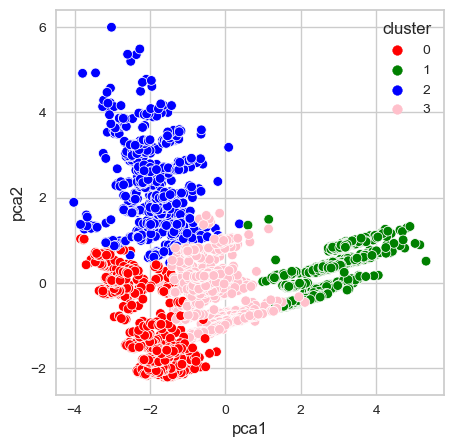

In [197]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','pink','yellow','gray','purple', 'black'])
plt.show()

## APPLY AUTOENCODERS (PERFORM DIMENSIONALITY REDUCTION USING AUTOENCODERS)

In [222]:
import os
os.environ['PYTHONHASHSEED']=str(10)

import random
random.seed(10)

from numpy.random import seed
seed(10)

import tensorflow
tensorflow.random.set_seed(10)

encoding_dim = 7

input_df = Input(shape=(10,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution 

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(10, activation='relu', kernel_initializer = 'glorot_uniform')(x)

x = Dense(2000, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(10, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')


In [223]:
scaled_df.shape

(4640, 10)

In [224]:
autoencoder.fit(scaled_df, scaled_df, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25
37/37 [==============================] - 3s 33ms/step - loss: 0.5094
Epoch 2/25
37/37 [==============================] - 1s 34ms/step - loss: 0.2393
Epoch 3/25
37/37 [==============================] - 1s 35ms/step - loss: 0.1720
Epoch 4/25
37/37 [==============================] - 1s 33ms/step - loss: 0.1339
Epoch 5/25
37/37 [==============================] - 1s 34ms/step - loss: 0.1074
Epoch 6/25
37/37 [==============================] - 1s 34ms/step - loss: 0.0951
Epoch 7/25
37/37 [==============================] - 1s 34ms/step - loss: 0.0805
Epoch 8/25
37/37 [==============================] - 1s 36ms/step - loss: 0.0730
Epoch 9/25
37/37 [==============================] - 1s 32ms/step - loss: 0.0691
Epoch 10/25
37/37 [==============================] - 1s 32ms/step - loss: 0.0613
Epoch 11/25
37/37 [==============================] - 1s 33ms/step - loss: 0.0523
Epoch 12/25
37/37 [==============================] - 1s 32ms/step - loss: 0.0522
Epoch 13/25
37/37 [==================

In [225]:
autoencoder.save_weights('autoencoder.h5')

In [226]:
pred = encoder.predict(scaled_df)

145/145 [==============================] - 1s 4ms/step


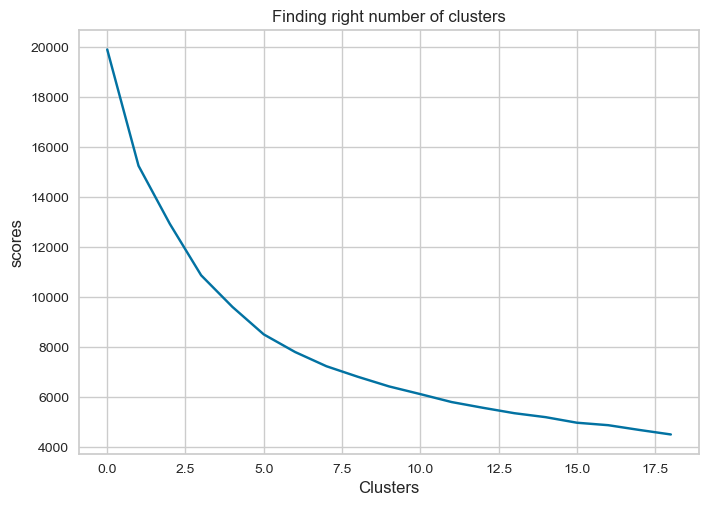

In [227]:
scores_2 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(pred)
  scores_2.append(kmeans.inertia_)

plt.plot(scores_2, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

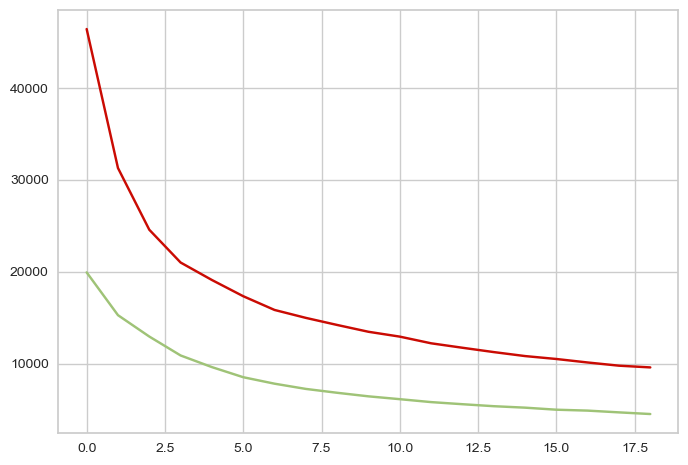

In [228]:
plt.plot(scores_1, 'bx-', color = 'r')
plt.plot(scores_2, 'bx-', color = 'g')

In [229]:
kmeans_ae = KMeans(4, random_state=5)
kmeans_ae.fit(pred)
labels_ae = kmeans_ae.labels_
y_kmeans_ae = kmeans_ae.fit_predict(scaled_df)

In [230]:
df_cluster_dr = pd.concat([numerical_df, pd.DataFrame({'cluster':labels_ae})], axis = 1)
df_cluster_dr.head()

age  duration  campaign  pdays  previous  emp_var_rate  cons_price_idx  \
75   41.0    1575.0       1.0  999.0       0.0           1.1          93.994   
83   49.0    1042.0       1.0  999.0       0.0           1.1          93.994   
88   49.0    1467.0       1.0  999.0       0.0           1.1          93.994   
129  41.0     579.0       1.0  999.0       0.0           1.1          93.994   
139  45.0     461.0       1.0  999.0       0.0           1.1          93.994   

     cons_conf_idx  euribor3m  nr_employed  cluster  
75           -36.4      4.857       5191.0      2.0  
83           -36.4      4.857       5191.0      2.0  
88           -36.4      4.857       5191.0      2.0  
129          -36.4      4.857       5191.0      2.0  
139          -36.4      4.857       5191.0      2.0

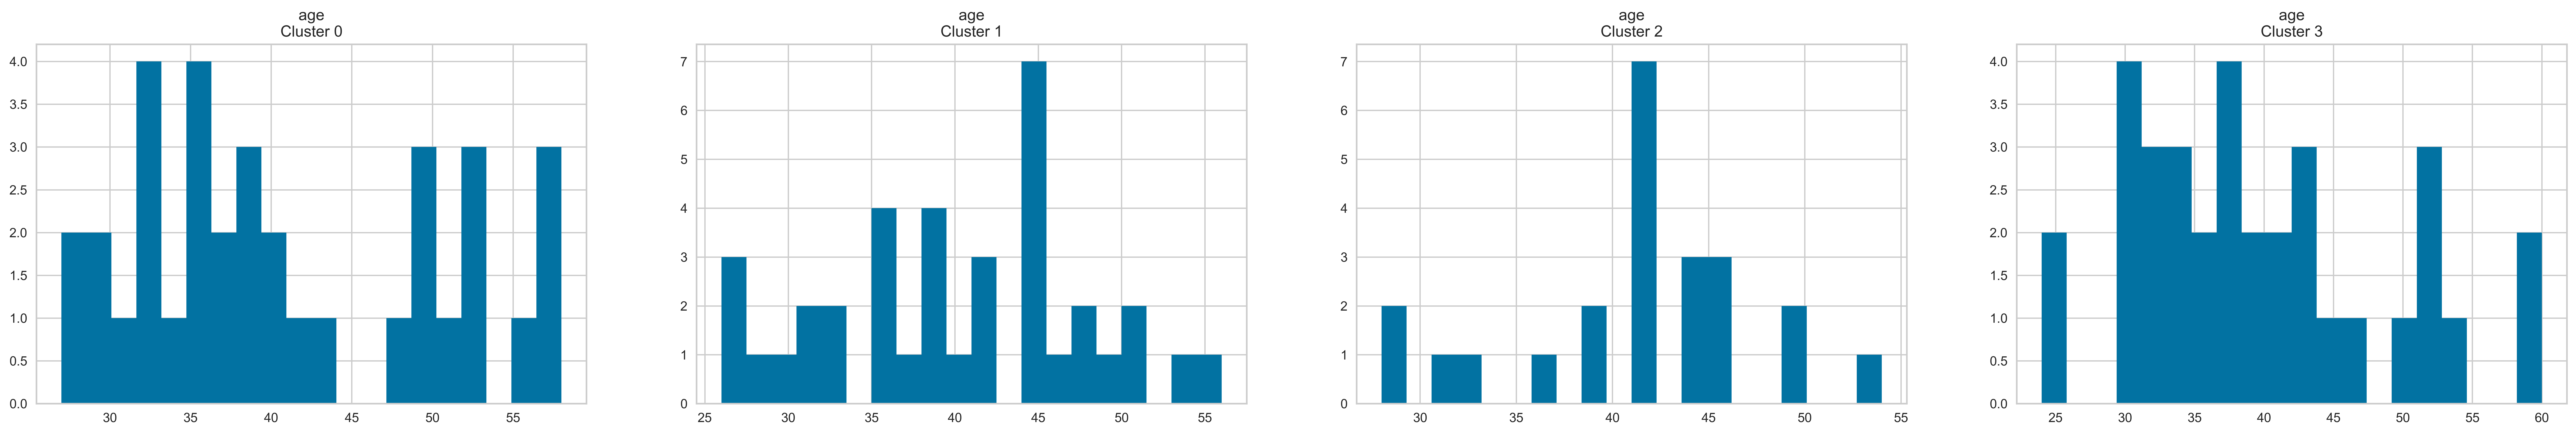

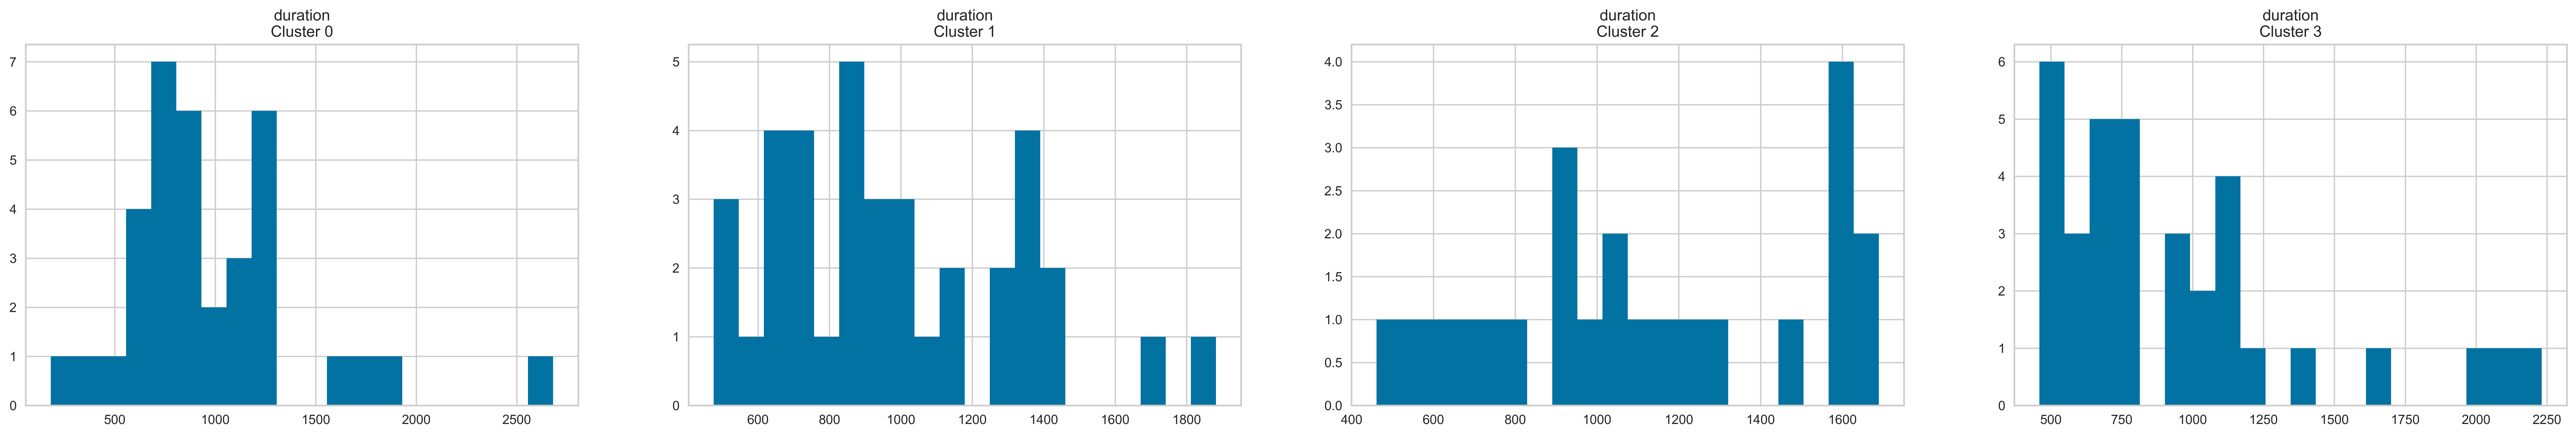

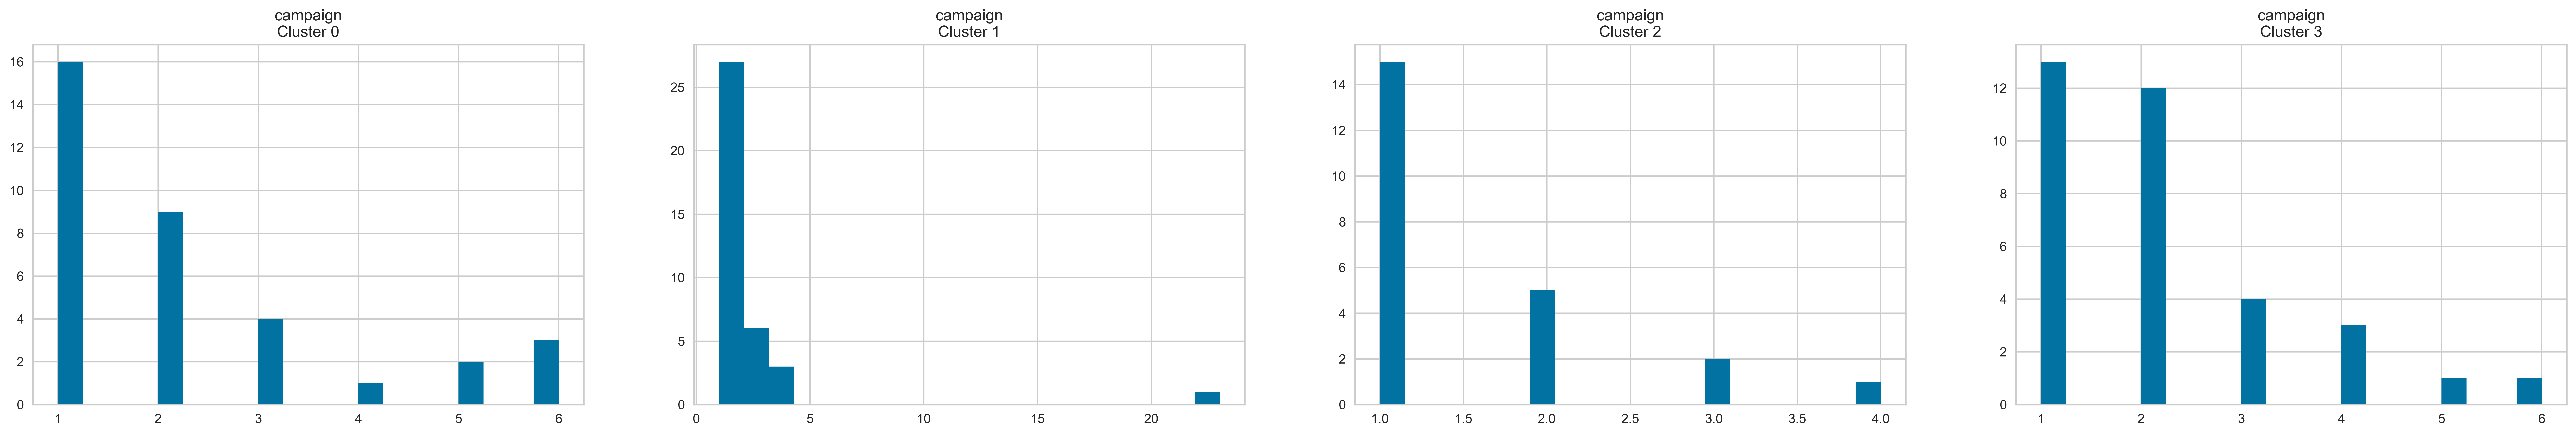

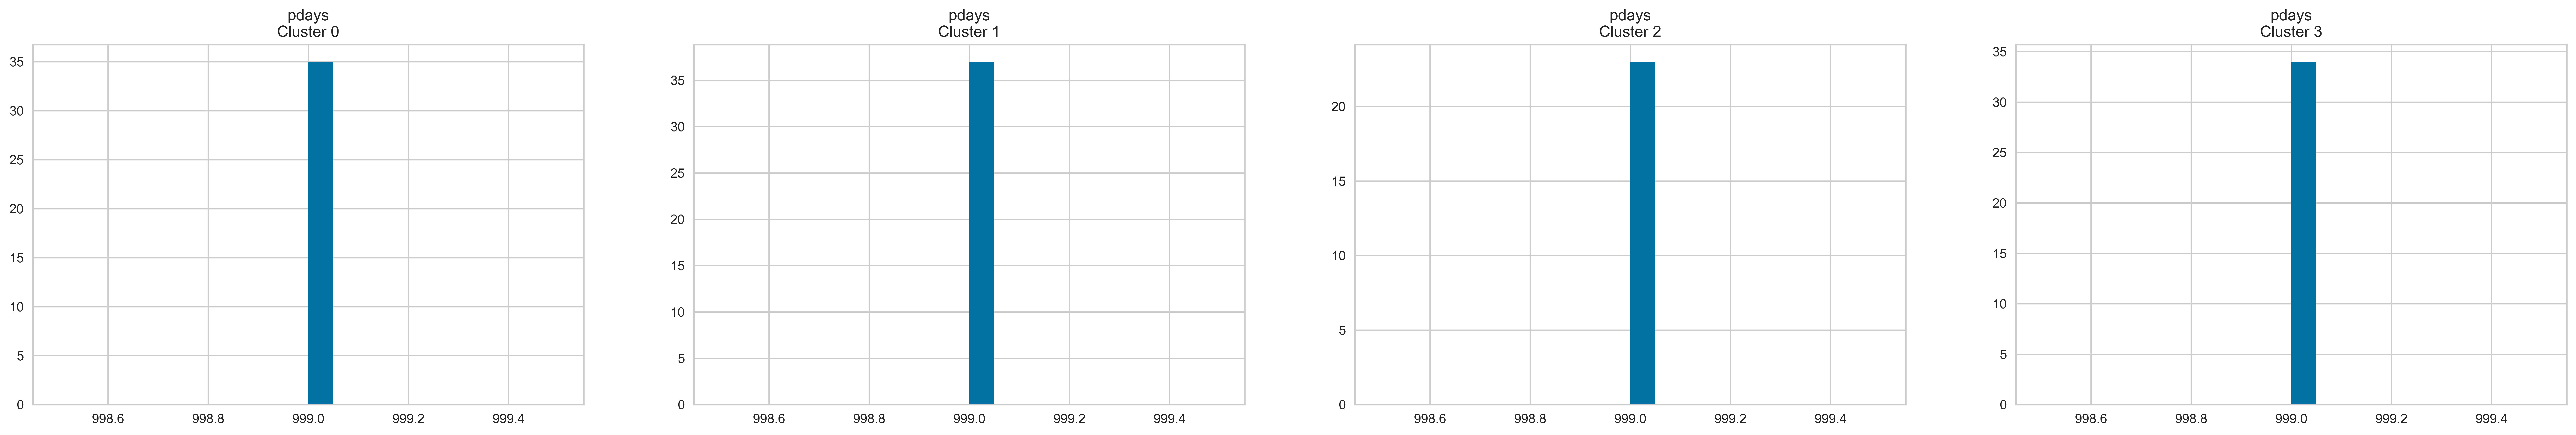

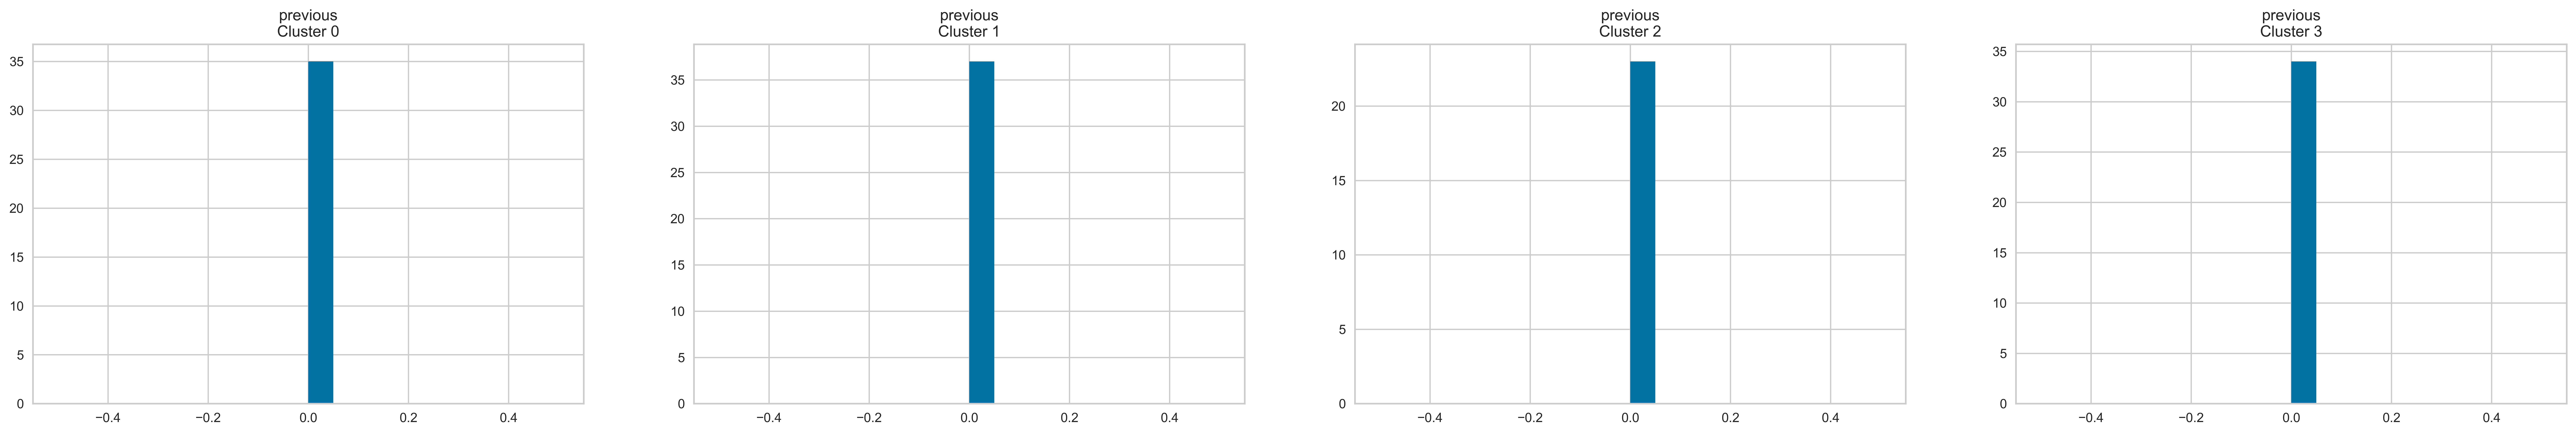

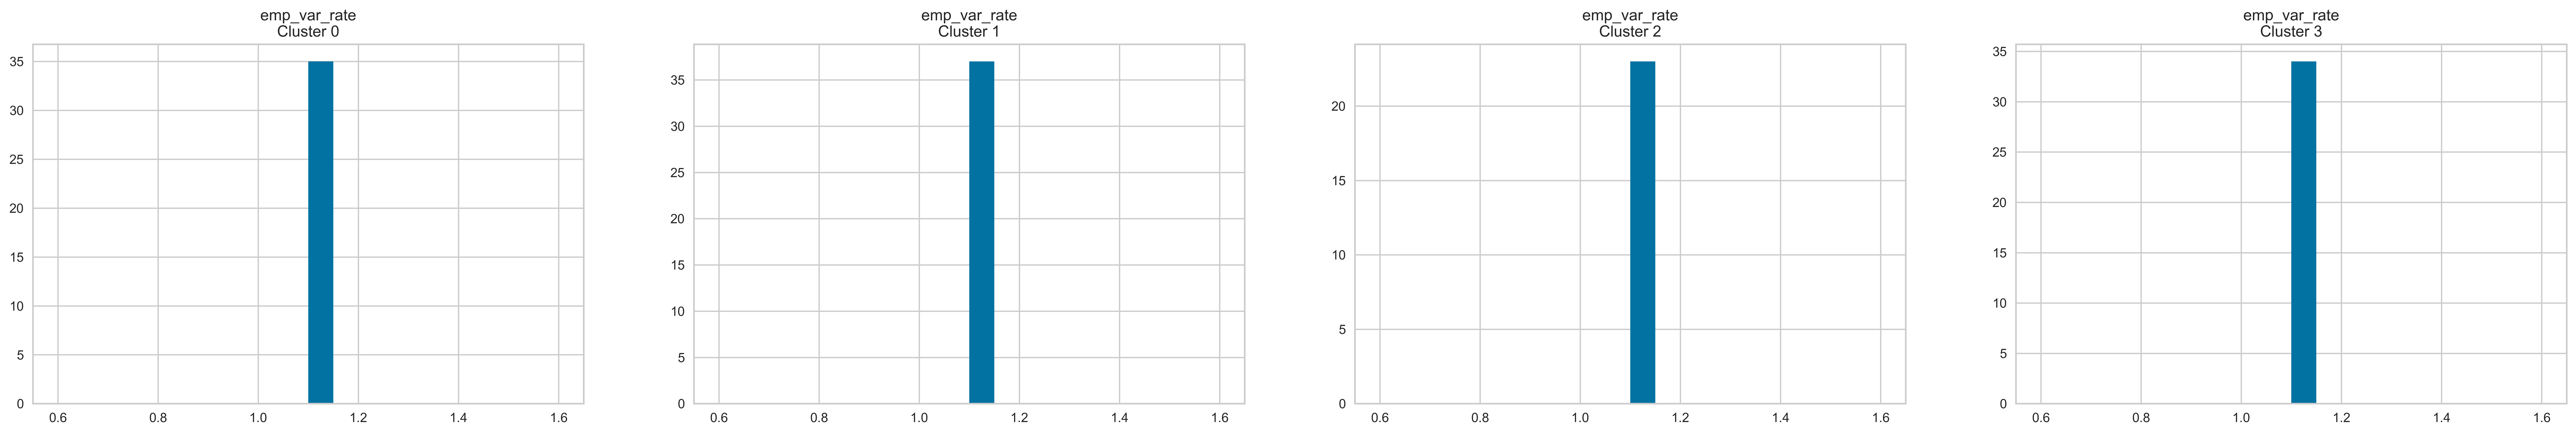

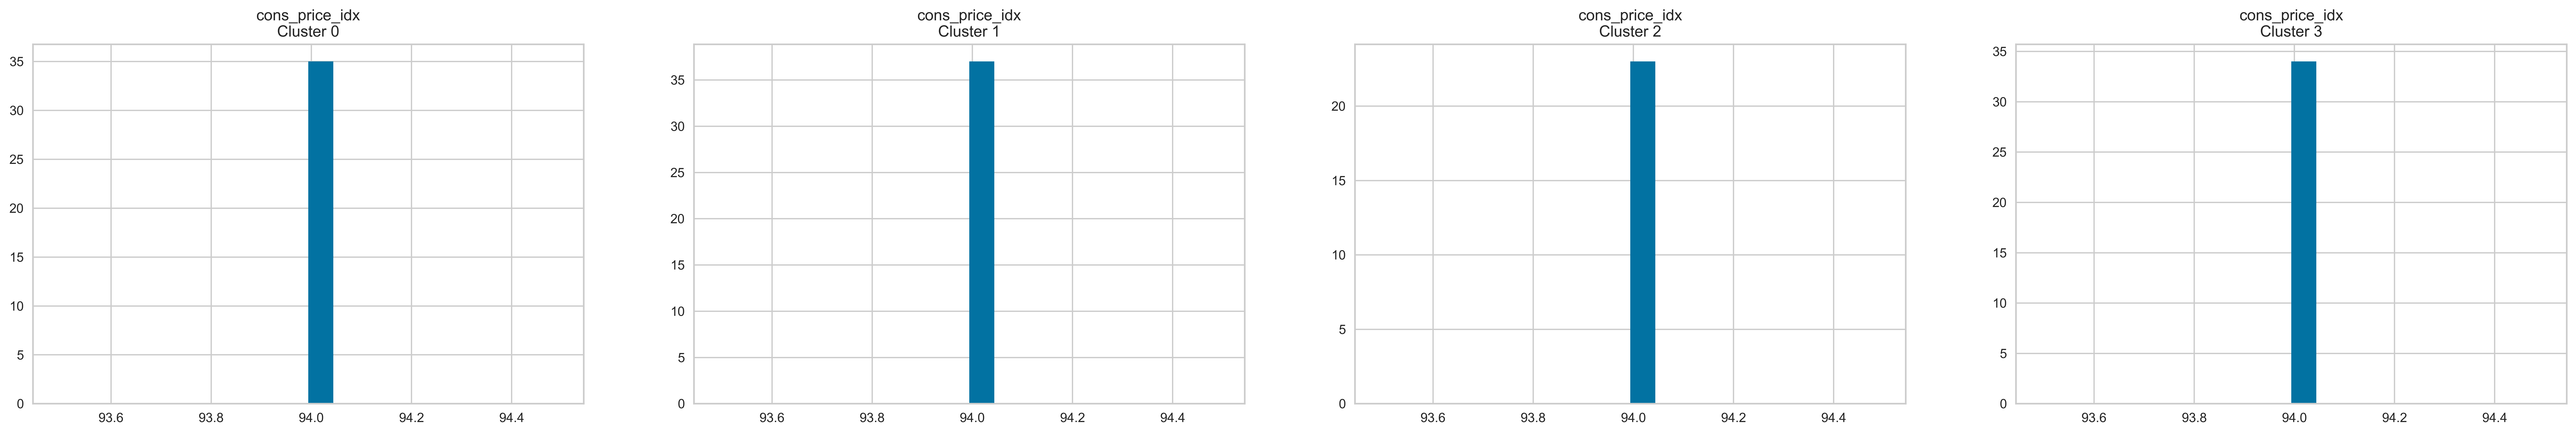

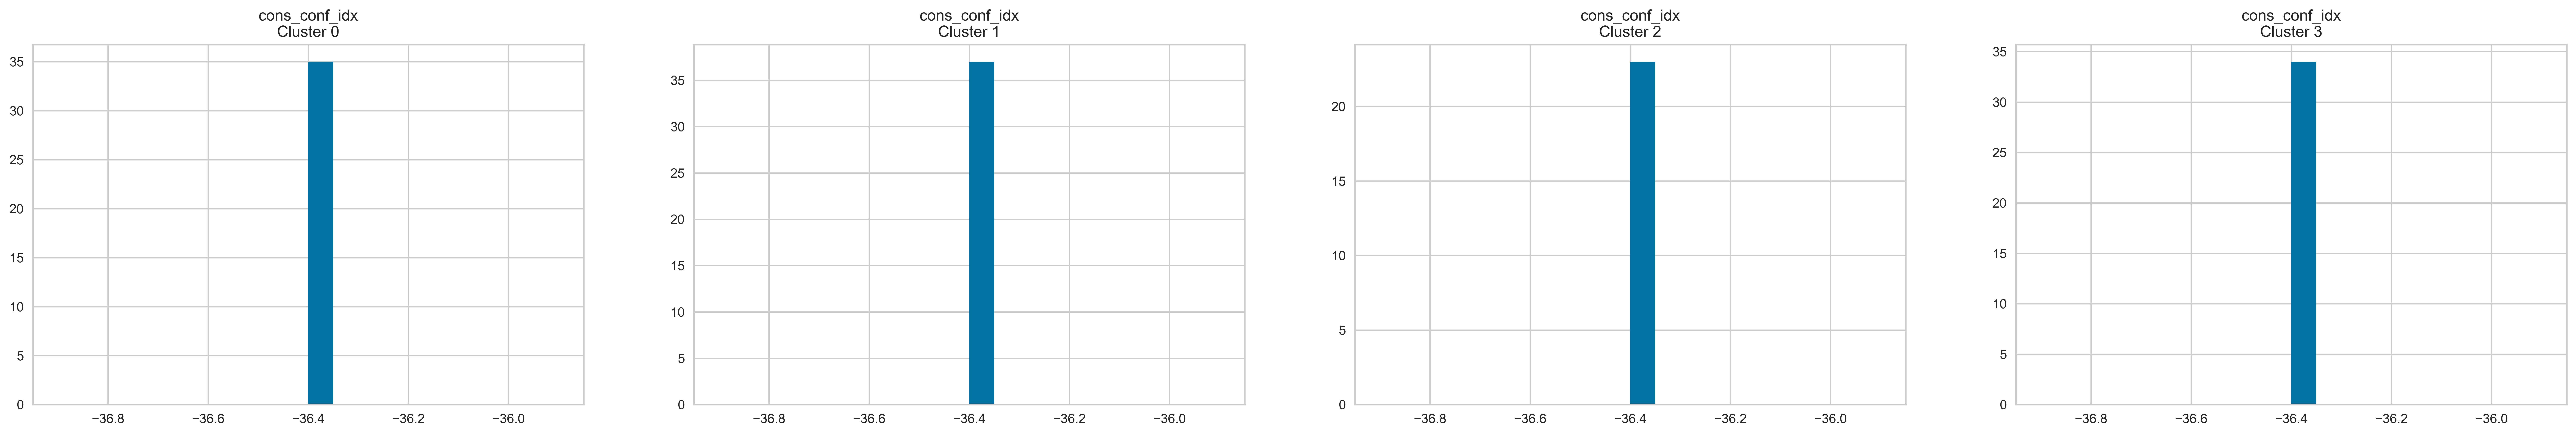

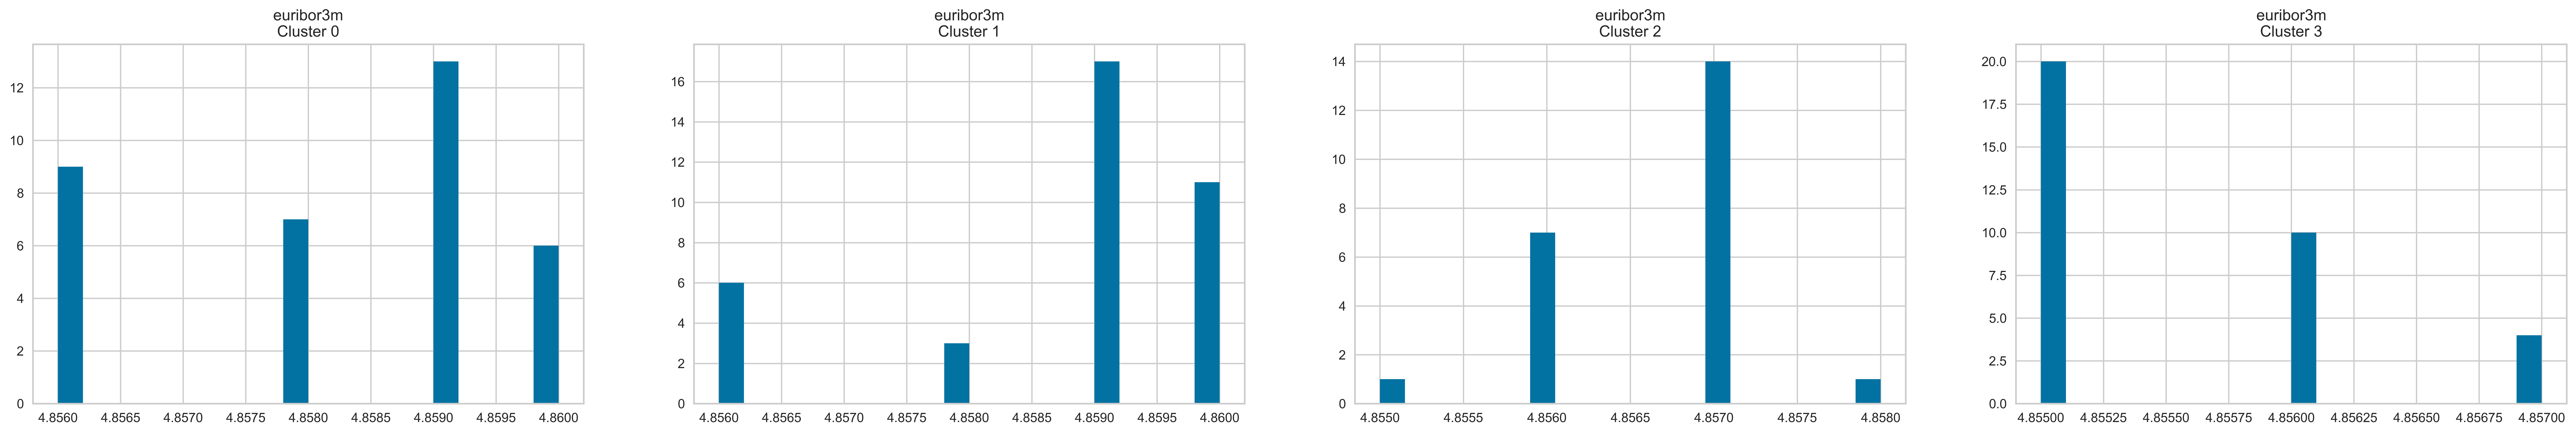

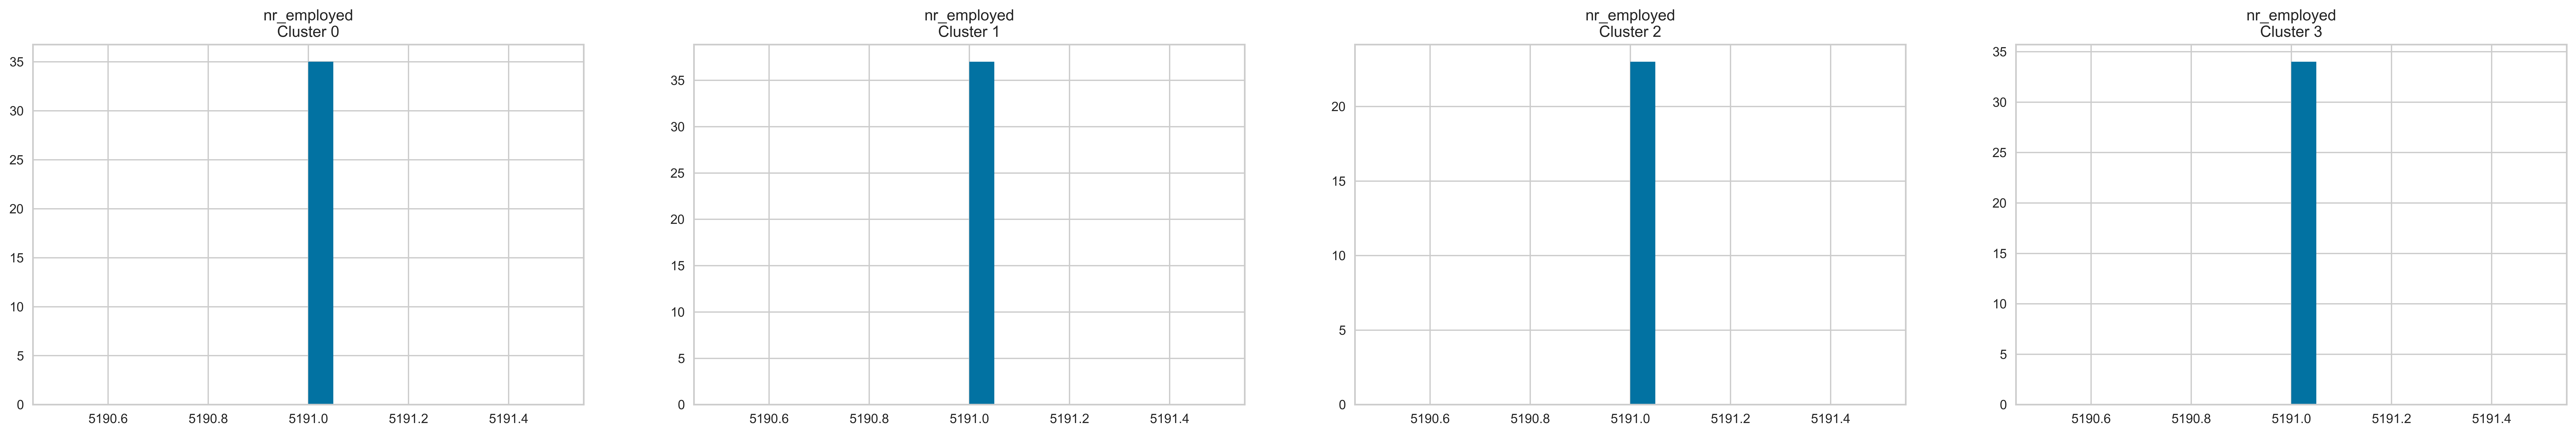

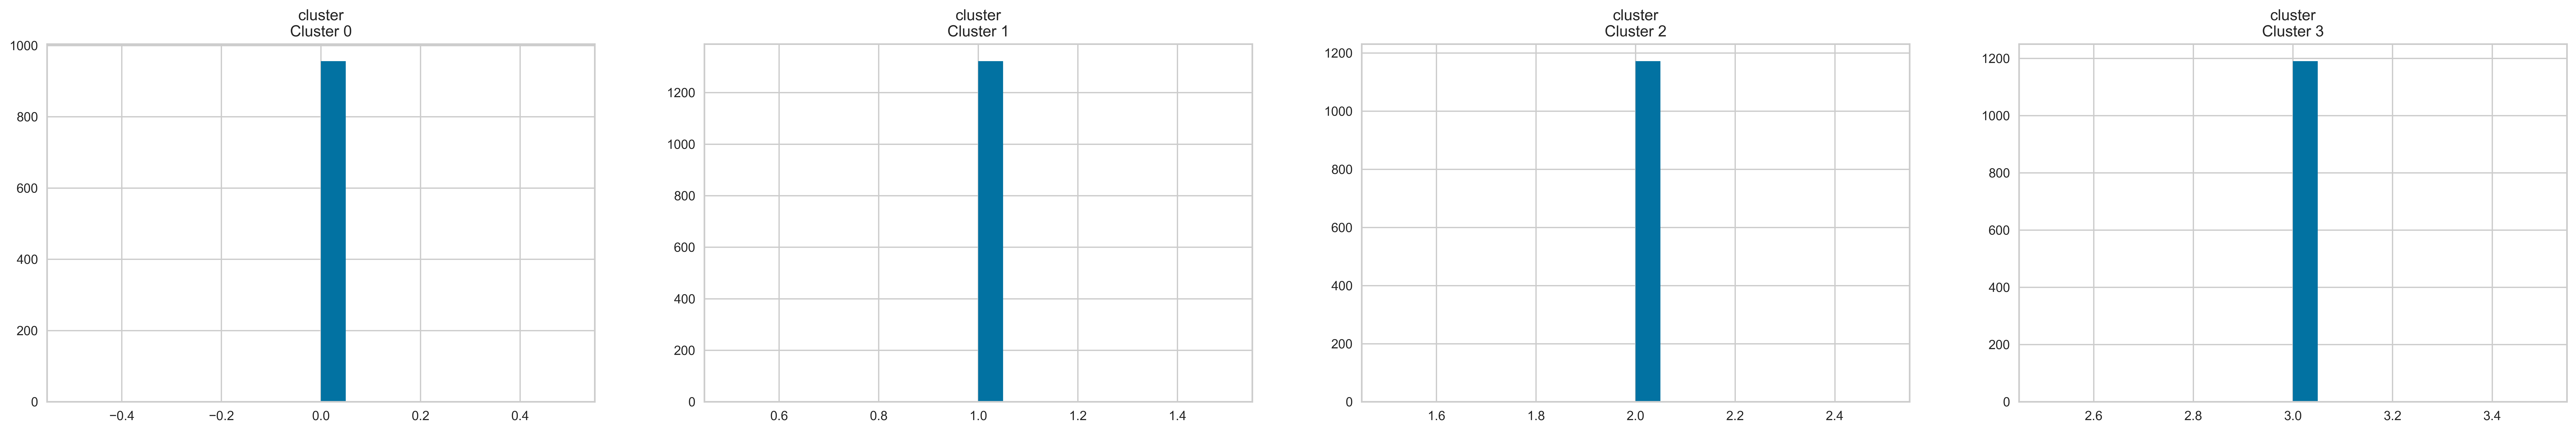

In [231]:
#--each row of figures represents feature distribution for each cluster-----#
for i in df_cluster_dr.columns:
    plt.figure(figsize = (35, 5), dpi = 500)
    for j in range(4):
        plt.subplot(1, 4, j+1)
        cluster = df_cluster_dr[ df_cluster_dr['cluster'] == j ]
        cluster[i].hist(bins  = 20)
        plt.title( '{}\nCluster {}'.format(i, j))
plt.show()

In [232]:
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df.head()

pca1      pca2
0  1.218995 -0.604320
1  0.813750 -0.693079
2  1.356733 -0.341734
3  0.015111 -1.408710
4  0.067979 -1.275810

In [233]:
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels_ae})], axis = 1)
pca_df.head()

pca1      pca2  cluster
0  1.218995 -0.604320        2
1  0.813750 -0.693079        2
2  1.356733 -0.341734        2
3  0.015111 -1.408710        2
4  0.067979 -1.275810        2

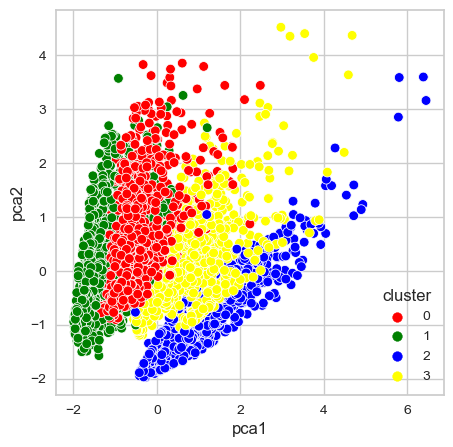

In [234]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['red','green','blue','yellow'])
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
print('kmeans: {}'.format(silhouette_score(scaled_df, kmeans_ae.labels_, metric='euclidean')))
print('kmeans: {}'.format(silhouette_score(scaled_df, kmeans_ae.labels_, metric='euclidean')))